In [1]:
from torch.utils.data import DataLoader, Dataset
import torchvision.transforms as T
import torch
import torch.nn as nn
from torchvision.utils import make_grid
from torchvision.utils import save_image
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import random
%matplotlib inline

In [2]:
import pathlib
import os

In [3]:
has_mps = getattr(torch, "has_mps", False)
device = "mps" if has_mps else "cpu"

In [4]:
TUMOR_DIR = "Brain Tumor"
HEALTHY_DIR = "Healthy"
IMAGE_SIZE = (128,128)

In [5]:
tumors = []
for (top, dirs, files) in os.walk(TUMOR_DIR):
    for pic in files:
        if pic.split('.')[-1].lower() in ['png','jpg','tif']:
            im = Image.open(os.path.join(top, pic)).convert('L').resize(IMAGE_SIZE)
            data = np.asarray(im)
            tumors.append(data)
tumor_label = [1]*len(tumors)

In [6]:
healthy = []
for (top, dirs, files) in os.walk(HEALTHY_DIR):
    for pic in files:
        if pic.split('.')[-1].lower() in ['png','jpg','tif']:
            im = Image.open(os.path.join(top, pic)).convert('L').resize(IMAGE_SIZE)
            data = np.asarray(im)
            healthy.append(data)
healthy_label = [0]*len(healthy)

In [7]:
X = np.array(tumors+healthy).astype("float")
y = np.array(tumor_label+healthy_label).astype("float")


In [8]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
# standarization
original_shape = X_train.shape
reshaped_train = X_train.reshape(original_shape[0]*original_shape[1], -1)
scaler = StandardScaler()
reshaped_train = scaler.fit_transform(reshaped_train)
X_train = reshaped_train.reshape(original_shape)

test_shape = X_test.shape
reshaped_test = X_test.reshape(test_shape[0]*test_shape[1],-1)
reshaped_test = scaler.transform(reshaped_test)
X_test = reshaped_test.reshape(test_shape)

In [10]:
# define a data class
class brainTumorDataset(Dataset):
    def __init__(self,X,y):
        self.X = X
        self.y = y
        
    def __len__(self):
        return len(self.y)

    def __getitem__(self,index):
        image = torch.from_numpy(self.X[index].astype(np.float32)).unsqueeze(0)  # Convert to float32 for better compatibility with PyTorch
        label = self.y[index].astype(np.float32).reshape(-1)  # Assuming labels are integer classes
        return image, label

In [11]:
train_dataset = brainTumorDataset(X_train,y_train)
test_dataset = brainTumorDataset(X_test,y_test)

In [12]:
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Build Neural Network

In [13]:
from torch.nn import Module
from torch.nn import Conv2d
from torch.nn import Linear
from torch.nn import MaxPool2d
from torch.nn import ReLU
from torch.nn import Sigmoid
from torch import flatten

In [14]:
class LeNet(Module):2kj
    def __init__(self, numChannels):
        super(LeNet, self).__init__()

        self.conv1 = Conv2d(in_channels=numChannels, out_channels=20, kernel_size=(5,5),padding=2)
        self.relu1 = ReLU()
        self.maxpool1 = MaxPool2d(kernel_size=4, stride=4)

        self.conv2 = Conv2d(in_channels=20, out_channels=50, kernel_size = 5, padding=2)
        self.relu2 = ReLU()
        self.maxpool2 = MaxPool2d(kernel_size=2, stride=2)

        self.fc1 = Linear(in_features=12800, out_features=500)
        self.relu3 = ReLU()

        self.fc2 = Linear(in_features=500, out_features = 1)
        self.sigmoid = Sigmoid()

    def forward(self, x):
        x = self.conv1(x)
        x = self.relu1(x)
        x = self.maxpool1(x)
        # pass the output from the previous layer through the second
        # set of CONV => RELU => POOL layers
        x = self.conv2(x)
        x = self.relu2(x)
        x = self.maxpool2(x)
        # flatten the output from the previous layer and pass it
        # through our only set of FC => RELU layers
        x = flatten(x, 1)
        x = self.fc1(x)
        x = self.relu3(x)
        # pass the output to our softmax classifier to get our output
        # predictions
        x = self.fc2(x)
        output = self.sigmoid(x)
        # return the output predictions
        return output

In [15]:
model = LeNet(numChannels=1).to(device)

In [16]:
optimizer = torch.optim.Adam(model.parameters(), lr = 1e-3)
# scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size = 5, gamma = 0.1)
lossFn = nn.BCELoss()

In [17]:
num_epochs = 10
losses = []
for epoch in range(num_epochs):
    model.train()
    for i, (inputs, labels) in enumerate(train_loader):
        inputs = inputs.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = lossFn(outputs, labels)
        loss.backward()
        optimizer.step()
        # scheduler.step()
    losses.append(loss.item())

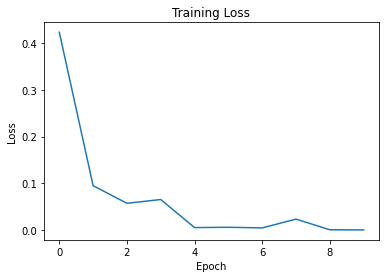

In [18]:
plt.plot(losses)
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

## Test

In [19]:
all_labels = []
all_preds = []

with torch.no_grad():  # Disable gradient computation
    for inputs, labels in test_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)
        outputs = model(inputs)
        preds = (outputs.squeeze() > 0.5).long()  # Threshold the output at 0.5 to get binary class labels
        all_labels.append(labels)
        all_preds.append(preds)

# Concatenate all the labels and predictions
all_labels = torch.cat(all_labels)
all_preds = torch.cat(all_preds)


In [20]:
from sklearn.metrics import accuracy_score, classification_report,confusion_matrix

# Convert to numpy arrays for use with sklearn
all_labels = all_labels.cpu().numpy()
all_preds = all_preds.cpu().numpy()

# Calculate accuracy
accuracy = accuracy_score(all_labels, all_preds)
print(f'Accuracy: {accuracy * 100:.2f}%')

# Print classification report
cm = confusion_matrix(all_labels, all_preds)
print(cm)


Accuracy: 96.95%
[[388  14]
 [ 14 503]]
